# Homework 2

## Monday, February 5, 2018

Today's class focuses on Support Vector Machines (SVMs), a method of doing maximum margin classification. 

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

#Generate dummy data and instantiate functions
#Run this cell to initialize homework

np.random.seed(10)
N=100

slope=np.random.uniform(-10,10)
bias=np.random.choice([np.random.uniform(-100,-90),np.random.uniform(90,100)])

#Define linear data
data=np.zeros((N,2))
data[:,0]=np.random.uniform(-20,20,N)
data[:,1]=slope*data[:,0]+np.random.normal(0,10,N)
data[int(N/2):,1]=data[int(N/2):,1]+bias

#Define labels for data
labels=np.ones(N)
labels[int(N/2):]=-1

#Define circular data
r1=np.random.uniform(1,5)
r2=np.random.uniform(7,10)
theta=np.random.uniform(0,2*np.pi,N)
np.random.normal(0,2,int(N/2))
data2=np.zeros((N,2))
data2[:int(N/2),:]=np.array([r1*np.cos(theta[:int(N/2)])+np.random.normal(0,0.5,int(N/2)),r1*np.sin(theta[:int(N/2)])+np.random.normal(0,0.5,int(N/2))]).T
data2[int(N/2):,:]=np.array([r2*np.cos(theta[int(N/2):])+np.random.normal(0,0.5,int(N/2)),r2*np.sin(theta[int(N/2):])+np.random.normal(0,0.5,int(N/2))]).T


#Classifier plotting function
def plot2DClassifier(B,B0):
    
    x1=np.linspace(-20,20,1000)
    x2=-1*(B[0]*x1+B0)/B[1]
    plt.plot(x1,x2,'k',linewidth=4)
    return

def plot1DClassifier(B,B0):
    
    x=-B0/B
    plt.plot(x,0,'|',ms=50,c='k')
    
    return

def plotData(X):
    plt.plot(X[:int(N/2),0],X[:int(N/2),1],'ro')
    plt.plot(X[int(N/2):,0],X[int(N/2):,1],'bo')
    return

def plotKernelData(phi,X):
    
    transformed_data=np.zeros(N)
    for i in range(N):
        transformed_data[i]=phi(X[i,:])
    
    plt.plot(transformed_data[:int(N/2)],np.zeros(int(N/2)),'ro')
    plt.plot(transformed_data[int(N/2):],np.zeros(int(N/2)),'bo')
    return

#Optimizing function
def optimize(func,constraint,X,Y):
    
    print ('Optimizing...(May take some time to run)')
    bound=[(0,None)]*N
    objective=lambda x: func(x,X,Y)
    equality_constraint=lambda x: constraint(x,X,Y)
    
    lagrange=opt.minimize(objective,x0=np.ones(N),bounds=bound,constraints={'type': 'eq', 'fun': equality_constraint})

    return lagrange.x

#Optimizing function
def plotSupportVectors(svs,X):
    
    for i in range(len(svs)):
        if svs[i]:
            plt.plot(X[i,0],X[i,1],'y*',ms=10)
    
    return

def plotKernelSVM(b):
    
    theta=np.linspace(0,2*np.pi,1000)
    plt.plot(b*np.cos(theta),b*np.sin(theta),'k')
    
    return

def transformData(phi,X):
    phiX=np.zeros((N,1))
    for i in range(N):
        phiX[i,0]=phi(X[i,:])
    return phiX

# Classification

Suppose we're given data points $x_i \in \mathbb{R}^n$ and $y_i \in \{-1,+1\}$, for $i = 1,\dots,N$. 

The $x_i$ are the features and $y_i$ are labels taking values in either $-1$ or $+1$. The $x_i$ could be the pixel intensities in an image of an animal, and $y_i$ could indicate whether the animal is a `cat` or ` dog`, for example. For machine learning, we want to get a good guess of what $y_i$ is from only looking at $x_i$; so, the computer algorithm can take in images and distinguish between cats and dogs. 

## Defining a linear classifier

Our dataset is then $(x_1,y_1),\dots,(x_N,y_N)$.

Now let's fix some parameters $\beta \in \mathbb{R}^n$ and $\beta_0 \in \mathbb{R}$. We can define a hyperplane as:

$$\{ x : x^{T} \beta + \beta_0 = 0 \}$$

This cuts our feature space, $\mathbb{R}^n$, in half. That is, every point in $\mathbb{R}^n$ is either above, below, or on this hyperplane. 

Let:

$$
f(x;\beta,\beta_0) = x^T \beta + \beta_0
$$

Sometimes, when it is obvious, we'll drop the dependence on $\beta,\beta_0$ and just denote this $f(x)$.

We can define a classifier:

$$
G(x) = 
\begin{cases}
+1 & \text{ if } f(x) \geq 0 \\
-1 & \text{ if } f(x) < 0
\end{cases}
$$

# Task 1: Linear Classifier

We begin by creating a function that takes in $\beta$ and $\beta_0$ and outputs a label for each datapoint. Note that $X \in \mathbb{R}^{N \times n}$ is a matrix of $N$ datapoints. In this example, $n = 2$.

In [2]:
def classify(beta,beta_0,X):        
    
        Yhat = ((X@beta + beta_0)>=0).astype(np.int64)
        Yhat[Yhat==0] = -1
        
        return Yhat



41 Data points were classified as +1
59 Data points were classified as -1
77 Data points were classified correctly




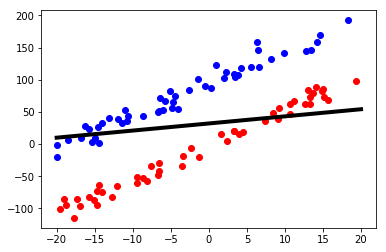

In [3]:
# Run this cell to test a classifier with a random linear separator

test_beta=np.array([slope/np.random.uniform(1,10),-1])
test_beta_0=bias/3.0

print()
print()
print (str(np.sum(classify(test_beta,test_beta_0,data)==1)) + ' Data points were classified as +1')
print (str(np.sum(classify(test_beta,test_beta_0,data)==-1)) + ' Data points were classified as -1')
print (str(np.sum(classify(test_beta,test_beta_0,data)==labels))+ ' Data points were classified correctly')
print()
print()


plt.figure()
plotData(data)
plot2DClassifier(test_beta,test_beta_0)

plt.show()

# Maximum Margin Classification

Having defined a general function that classifies points, we now try to find the maximum margin classifier.

Suppose our dataset is strongly separable. (Sanity check: Is the data we are using separable by a hyperplane?). There are infinitely many hyperplanes that can separate this data. Which one of these separators is 'best'? The answer is the one with the largest margin.

Recall from class that the problem that maximum margin classification is trying to solve is:

\begin{align*}
\min_{\beta,\beta_0}~ & \|\beta\|^2_2 \\
\text{subject to }~		& y_i (x_i^T \beta + \beta_0) \geq 1 \text{ for } i = 1,\dots,N \\
\end{align*}

Note that this problem has an inequality constraint for every datapoint. This can be hard to deal with when that amount of data we are using gets very high.

## Task 2: Maximum Margin Classifification through duality

We are going to solve this problem by formulating the dual problem. First derive lagrangian of the minimization above. 

$$
L(\beta,\beta_0,\mu)= \|\beta\|^2_2 + \sum_{i=1}^N \mu_i (1- y_i (x_i^T \beta + \beta_0))
$$

(Note that for some portion of the class, we separated our Lagrange multiplier into an $\alpha$ and a $\mu$ component. For the purposes of this homework, we will keep the Lagrange multipliers unified with the single vector $\mu$. This will make coding easier.)

Note, the optimization problem is now:

\begin{align*}
\min_{\beta,\beta_0} \max_{\mu\ge0}~ &  L(\beta,\beta_0,\mu)
\end{align*}

Due to the convexity of the problem, we can rewrite this as:

\begin{align*}
\max_{\mu\ge0} \min_{\beta,\beta_0}~ &  L(\beta,\beta_0,\mu)
\end{align*}

This equivalence is often referred to as **strong duality**.

By solving the now unconstrained minimization:

$$
\min_{\beta,\beta_0} \ \ L(\beta,\beta_0,\mu)
$$

Formulate a problem in the form:

\begin{align*}
\min_{\mu \ge 0}~ & f(\mu) \\
\text{subject to }~	& g(\mu)=0 \\
\end{align*}

Note that in this dual form, you only have 1 equality constraint.
(Hint: Solve for the optimality conditions of $\beta$ and $\beta_0$)

## Task 3: Dual problem formulation

Note you have access to the data $x_1,...x_N$ and the labels $y_1,...y_N$.

$$
% f(\mu)= 1/4*(\sum_{i=1}^N \mu_i y_i x_i^T)^T (\sum_{i=1}^N \mu_i y_i x_i^T) + \sum_{i=1}^N \mu_i (1- y_i (x_i^T \sum \mu_i y_i x_i^T/2))
f(\mu)= \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \mu_i y_i x_i^T x_j y_j \mu_j - \sum_{i=1}^N \mu_i 
$$

$$
g(\mu)= \sum_{i=1}^N \mu_i y_i
$$

Given the dual problem formulation above, we will now use the scikit learn python library to solve the dual, and thus the primal problem. 

# Task 4: code the dual problem

In [4]:
# Write out functions h, and g above, taking in the vector of lagrange multipliers mu
# Once you have written the functions, we will call scipy-optimize (this is done for you).

def f(mu,X,Y):
    
#     2 beta - \sum \mu_i y_i x_i^T = 0
#     2 \beta = \sum \mu_i y_i x_i^T
#     beta = \sum \mu_i y_i x_i^T/2

#     \sum \mu_i y_i = 0
#     \|\sum \mu_i y_i x_i^T/2\|^2_2 + \sum_{i=1}^N \mu_i (1- y_i (x_i^T \sum \mu_i y_i x_i^T/2 + \beta_0))
    
    res = -np.sum(mu)
    
    for i in range(len(Y)):
        for j in range(len(Y)):
            res += 1/2*mu[i]*mu[j]*Y[i]*Y[j]*X[i,:].T@X[j,:]
    
    return res

def g(mu,X,Y):
    
    return mu.T@Y

Now given the Lagrange multipliers, find $\beta$ and $\beta_0$:

In [5]:
# Take in the vector of lagrange multipliers and calculate B, and B_0

def lagrange_to_classifier(mu,X,Y):
    
    beta=0
    for i in range(len(mu)):
        beta+=mu[i]*X[i,:]*Y[i]
    
    for i in range(len(mu)):
        if mu[i]==np.max(mu):
            beta_0=Y[i]-np.dot(beta,X[i,:])
    
    return beta, beta_0

# Final SVM

Now you can run the cell below to see the results of your coding.

Optimizing...(May take some time to run)


50 Data points were classified as +1
50 Data points were classified as -1
77 Data points were classified correctly




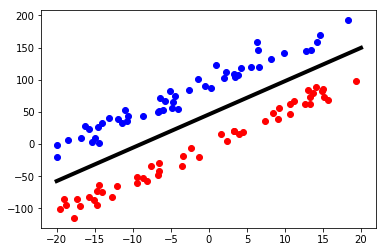

In [6]:
# Run this cell to see the results

lagrange_multipliers=optimize(f,g,data,labels)
beta,beta_0=lagrange_to_classifier(lagrange_multipliers,data,labels)

print()
print()
print (str(np.sum(classify(beta,beta_0,data)==1)) + ' Data points were classified as +1')
print (str(np.sum(classify(beta,beta_0,data)==-1)) + ' Data points were classified as -1')
print (str(np.sum(classify(test_beta,test_beta_0,data)==labels))+ ' Data points were classified correctly')
print()
print()

plt.figure()
plot2DClassifier(beta,beta_0) 
plotData(data)
plt.show()

The data points that determine the maximum margin are commonly referred to as 'support vectors'. These are the data points that determine the separating hyperplane. From the lagrange multipliers you found above, find the support vectors of your classifier.



# Task 5: Finding the support vectors

Given the Lagrange multipliers you found previously, how can you find the support vectors of your classifier? Write out how you propose to find the support vectors of your classifier from the lagrange multipliers below:

## Task 5 written response:
Per lecture 3, since support vectors are made of the points closest to the margin, we know that only at the margin does the coefficient $\mu$ start to kick-in and take a value greater than 0.

# Task 6: implement Task 5

Given the Lagrange multipliers $\mu \in \mathbb{R}^N$, and your data points $X\in \mathbb{R}^{N \times n}$ where $n=2$, write code that returns a length $N$ numpy array with $1$ if data point $X_i=X[i,:]$ is a support vector, and $0$ otherwise.

In [7]:
def findSupportVectors(mu,X):
    
    return mu>0

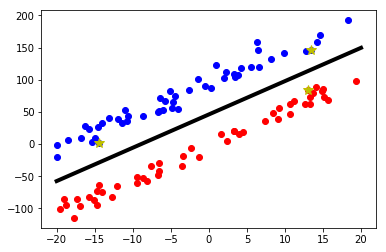

In [8]:
support_vectors=findSupportVectors(np.round(lagrange_multipliers,10),data)

plt.figure()
plot2DClassifier(beta,beta_0) 
plotData(data)
plotSupportVectors(support_vectors,data)
plt.show()

# Kernel SVM

Most of the time the data points are not linearly separable as they are. In the next section we are going to learn about Kernel SVM. The high-level idea is to 'project' each data point into a space in which they are linearly separable and find the classifier in that space. 

Given data $x_1,...x_N$, where $x_i \in \mathbb{R}^n$, such that the data is not strictly linearly spearable, our goal is to find a mapping $\phi: \mathbb{R}^n \rightarrow \mathbb{R}^k$ in which the data points are strictly separable. 

In the next section you will try to find a mapping that does this:


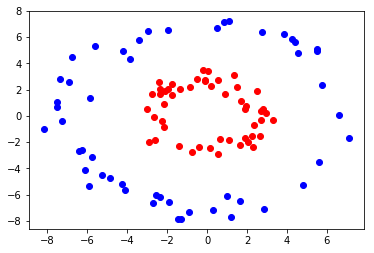

In [9]:
# Run this to see the kernel SVM data

plt.figure()
plotData(data2)
plt.show()

# Task 7: Choosing a Kernel 

Given the data above, design a mapping $\phi: \mathbb{R}^n \rightarrow \mathbb{R}^k$, that takes a data point $x=[x_1,x_2]^T \in \mathbb{R}^2$ and projects it into $\mathbb{R}$, where it is linearly separable.

In [10]:
def phi(x):
    return x[0]**2 + x[1]**2

Your transformed data looks like:


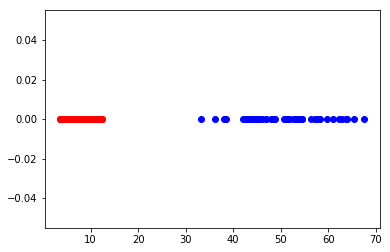

In [11]:
plotKernelData(phi,data2)

print('Your transformed data looks like:')
plt.show()

Now perform SVM on your kernelized data. Note that data is now in $\mathbb{R}$, so you may have to go back and adjust your code so that it works in any dimension.

Optimizing...(May take some time to run)


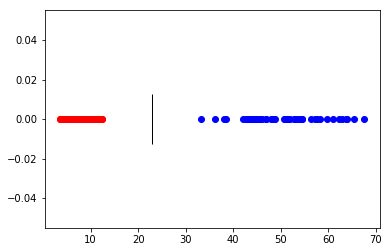

In [12]:
#Run this cell to perform SVM on the projected data using your function phi above

td=transformData(phi,data2)
mu=optimize(f,g,td,labels)
kernel_beta,kernel_beta_0=lagrange_to_classifier(mu,td,labels)


plt.figure()
plot1DClassifier(kernel_beta,kernel_beta_0) 
plotKernelData(phi,data2)
plt.show()

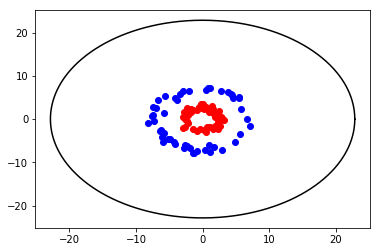

In [13]:
#Run this cell to see what the classifier you found looks like in the original space, 
#as well as the support vectors for the data

support_vectors=findSupportVectors(np.round(mu,10),data)

plt.figure()
plotData(data2)
plotKernelSVM(-1*kernel_beta_0/kernel_beta)
plt.show()